## <span style="color:white">Data Science Immersive Capstone Project</span>
### <span style="color:#CCC">Chris Huber, chrishubersf@gmail.com</span>
#### <span style="color:#AAA">A predictive study of edible wild mushroom growth in the greater San Francisco Bay Area</span>

### <span style="color:white">Problem Statement</span>
<div style="margin-left: 30px; margin-right: 30px;">
<p>Given prior data records of findings of edible wild edible mushroom species with latitude/longitude coordinates, species names, dates of sightings, weather conditions, <strikethrough>substrate composition</strikethrough>, and other relevant factors can I predict for a given period the likelihood of finding certain species of mushrooms that grow natively in the Bay Area.</p>
</div>

#### Add modeling hows/steps/flowchart? (going forward)
#### Visualizations

### <span style="color:white">Proposed Methods and Models</span>
<div style="margin-left: 30px; margin-right: 30px;">
<p>I propose to use MySQL as a database backend and Python/Pandas as the main technologies to analyze and deliver my findings</p>
<p>Sourcing the data is tricky: the records I have been able to find are often partial, imperfect, and even potentially inaccurate. However, the source is a reputable and well-known one among mycologists and as such I should be able to detect improperly formatted or submitted data with some thorough EDA.</p>
<p>An abundance of weather data has been and continues to be published daily by the U.S. Meterological Service and as such I should be able to import the relevant data from their website.</p>
<p>Mushrooms blooms in the Bay Area tend to occur during wet winter seasons. However, if the winter is dry they can be delayed until the spring. I intend to look at the correlation between the reported find dates and seasonal variations in temperature, precipitation, and humidity.
</div>

### <span style="color:white">Risks and Assumptions of Data</span>
<div style="margin-left: 30px; margin-right: 30px;">
<p>One of the major risks of this dataset is that it does not record quantity, simply occurrences. This means that while the mushrooms of the same species typically grow in a given area, there is no guarantee of the amount. Thus, this should not be seen as a guide to finding any particular amount of a given mushroom but rather its existence in an area.</p>
<p>Another risk is that the mushroom-related data is user-entered and as such could be erroneous or even outright false. However, there would be no perceivable benefit to falsifying this type of data so I do not forsee this being a major issue. I will need to monitor for gross anomolies in the data in cae this type of phenomenon exists.</p>
</div>

### <span style="color:white">Data Sources</span>
<div style="margin-left: 30px; margin-right: 30px;">
<p>
My main data source is a MySQL database dump that the curator for Mushroom Observer, a user-submitted mushroom documenting website, released to me. I also have data listing the species of mushrooms showcased at the San Francisco Fungus Fair (SFFF) and the general location where they were found. If possible, I intend to combine as much data as I can from different sources to create an even more robust dataset.
</p>
</div>

### <span style="color:white">Importing all Required Python Libraries</span>

In [688]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import MySQLdb
import math
import mplleaflet

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, RobustScaler
# from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, BaggingClassifier, RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder

ss = StandardScaler()
skb = SelectKBest(f_classif, k=6)

from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 999)

### <span style="color:white">Creating a MySQL Connection</span>

In [1721]:
mysql_cn= MySQLdb.connect(host='localhost', 
                port=3306,user='capstone', passwd='mushr0Om', 
                db='mushroom_observer')
mush_obsv_df = pd.read_sql('SELECT * from bay_area_observations;', con=mysql_cn)
mush_obsv_df = mush_obsv_df.set_index(['id'])
mush_names_df = pd.read_sql('SELECT * from bay_area_names;', con=mysql_cn)
mush_names_df = mush_names_df.set_index(['id'])
mush_locs_df = pd.read_sql('SELECT * from bay_area_locations;', con=mysql_cn)
mush_locs_df = mush_locs_df.set_index(['id'])

mush_locs_df.head(1)

version          created_at          updated_at  user_id  description_id  \
id                                                                             
21  3       2008-01-04 22:48:03 2010-08-14 01:56:45  1       NaN               

    rss_log_id  num_views           last_view    north   south     west  \
id                                                                        
21 NaN          219       2018-09-05 19:40:30  38.1464  38.039 -122.624   

       east  high  low  ok_for_export  \
id                                      
21 -122.486 NaN   NaN   1               

                                                                                                                                     notes  \
id                                                                                                                                           
21  [admin - Sat Aug 14 01:56:45 +0000 2010]: Changed location name from 'Novato, Marin Co., California, USA' to 'Novato, California, USA'   

                       name          scientific_name  locked  
id                                                            
21  Novato, California, USA  USA, California, Novato  0

### Edible Mushroom List
<pre>
Agaricus augustus - The Prince (not choice)
Agaricus subrutilescens - Wine-colored Agaricus (choice)
Amanita augusta - Blushing Yellow Veil Amanita (not choice)
Amanita caesarea - Caesar's Mushroom
Amanita calyptroderma - Coccora, Coccoli
Amanita novinupta - Blusher (choice)
Amanita sect. Vaginatae (Amanita vaginata) - Grisette (not choice)
Amanita velosa - Springtime Amanita
Armillaria mellea
Auricularia auricula-judae - Jew's ear, wood ear, or jelly ear mushroom
Boletus badius - Bay Bolete
Boletus edulis - Porcini mushroom
Boletus edulis var. grandedulis
Boletus regineus - Queen Bolete (choice)
Calvatia gigantea - Giant Puffball
Cantharellus californicus - oak chanterelle (choice)
Cantharellus cibarius - yellow chanterelle (choice)
Cantharellus tubaeformis - tube or yellow-leg chanterelle
Chlorophyllum brunneum - Shaggy parasol (choice, but not recommended)
Clavaria fragilis - Fairy Fingers (not choice)
Clitocybe nuda (Lepista nuda) - Wood Blewit (choice)
Coprinellus micaceus - Mica Cap, Shiny Cap, and Glistening Inky Cap (choice)
Coprinus comatus - Shaggy Ink Cap/Mane, Lawyer's Wig (choice)
Entoloma medianox - Midnight Entoloma (choice)
Flammulina velutipes - Enoki mushroom (choice)
Gliophorus psittacinus - Parrot Toadstool, Parrot Waxcap *
Gomphidius oregonensis - Insidious Gomphidius (not choice) 
Grifola frondosa - Hen of the Woods
Gymnopus dryophilus (not choice)
Hericium erinaceus - lion's mane mushroom (choice)
Himematsutake - "princess matsutake"
Hydnum repandum - Hedgehog mushroom/Urchin of the Woods
Hypsizygus tessellatus/Hypsizygus marmoreus - beech mushroom, white/brown varieties
Laccaria amethysteo-occidentalis
Lacrymaria lacrymabunda (not choice) *
Lactarius deliciosus - Saffron Milk Cap
Lactarius rubidus - Candy Cap, Curry Milk Cap
Lactarius rufulus - Rufous Candy Cap
Laetiporus gilbertsonii *
Leccinum manzanitae - Manzanita Bolete (choice)
Lentinula edodes - shiitake (choice)
Morchella - Morel family
Morchella conica var. deliciosa - Morel
Morchella esculenta var. rotunda - Morel
Panaeolus papilionaceus - Petticoat mottlegill (not choice)
Pleurotus, Pleurotus ostreatus - oyster mushrooms
Pluteus cervinus - Deer Shield, Deer/Fawn mushroom (not choice)
Schizophyllum commune (not choice) *
Suillus fuscotomentosus
Suillus pungens - pungent slippery jack (not choice)
Tremella fuciformis - snow fungus, snow ear, silver ear fungus, and white jelly mushroom
Tricholoma matsutake - matsutake
Tuber aestivum - Black summer truffle
Tuber birch
Tuber brumale
Tuber indicum - Chinese black truffle
Tuber macrosporum - Smooth black truffle
Tuber mesentericum - The Bagnoli truffle
Volvariella volvacea - paddy straw mushroom or straw mushroom
Volvopluteus gloiocephalus - Big Sheath mushroom, Rose-Gilled Grisette, or Stubble Rosegill (not choice)
</pre>

* for some

### Medicinal Mushroom List
<pre>
Panaeolus foenisecii - Mower's Mushroom, Brown Hay Mushroom
Trametes betulina - Gilled Polypore, Birch Mazegill, Multicolor Gill 
Trametes versicolor - Turkey Tail
Tremella fuciformis - snow fungus, snow ear, silver ear fungus, and white jelly mushroom
</pre>

### Psychoactive Mushroom List
<pre>
Gymnopilus luteofolius - Yellow-Gilled Gymnopilus
Inocybe corydalina
Omphalotus olivascens
Panaeolus cinctulus (Panaeolus papilionaceus group) - Banded Mottlegill, Weed Panaeolus or Subbs
Psilocybe allenii
Psilocybe cyanescens - Wavy cap
</pre>

### Poisonous Mushroom List
<pre>
Agaricus californicus *
Agaricus hondensis - Felt-Ringed Agaricus
Agaricus xanthodermus *
Amanita amerimuscaria
Amanita gemmata - Gemmed Amanita
Amanita muscaria subsp. flavivolvata
Amanita phalloides
Amanita ocreata
Boletus eastwoodiae - Satan's Bolete *
Chlorophyllum molybdites - Vomiter Mushroom
Galerina marginata - Funeral Bell, Deadly Skullcap
Hebeloma crustuliniforme - Poison Pie, Fairy Cakes
Hypholoma fasciculare - Sulfur Tuft
Inocybe geophylla% - Common White Inocybe, Earthy Inocybe, White Fibercap
Leratiomyces ceres - Redlead Roundhead
Psathyrella
Omphalotus olivascens
Suillellus amygdalinus *

* for some
</pre>

### Other Scientific Interest List
<pre>
Amanita magniverrucata - Great Pine Jewel
Annulohypoxylon thouarsianum
Aureoboletus flaviporus
Bolbitius titubans
Caulorhiza umbonata
Clathrus ruber - Latticed Stinkhorn, Basket Stinkhorn, Red Cage
Coprinellus sect. Micacei
Coprinopsis lagopus - Harefoot mushroom
Cortinarius glutinosoarmillatus - Slimy Belt
Cortinarius subgenus Telamonia
Entoloma subgenus Leptonia
Entoloma subgenus Nolanea
Ganoderma brownii
Gymnopilus luteofolius
Gymnopilus ventricosus
Helvella dryophila
Hericium coralloides - Coral tooth
Hygrocybe acutoconica
Hygrocybe flavescens
Hygrocybe singeri
Hygrophorus eburneus - Ivory Waxy Cap or the Cowboy's Handkerchief *
Phaeolus schweinitzii - Velvet-top Fungus, Dyer's Polypore
Lactarius alnicola - Golden milk cap
Lactarius argillaceifolius var. megacarpus
Leratiomyces percevalii
Leucopaxillus albissimus
Marasmiellus candidus
Marasmius plicatulus
Mycena acicula - Orange Bonnet, Coral Spring
Mycena galericulata - Common Bonnet, Toque Mycena, Rosy-Gill Fairy Helmet
Mycena haematopus - Bleeding Fairy Helmet, Burgundydrop Bonnet
Mycena purpureofusca - Purple-Edge Bonnet
Panus conchatus - Lilac Oysterling
Psathyrella candolleana
Psathyrella longipes
Psathyrella piluliformis
Russula cremoricolor
Russula sanguinaria (Russula sanguinea) - Bloody Brittlegill
Stereum hirsutum - False turkey tail
Stropharia ambigua
Suillus caerulescens
Tremella aurantia - Golden ear
Tricholoma dryophilum
Tubaria furfuracea - Scurfy twiglet
Xylaria hypoxylon ("Xylaria hypoxylon group") - candlestick fungus, carbon antlers, stag's horn fungus
</pre>

### Defining lists to be used in filtering data

In [2263]:
choice_mushroom_list = ['Agaricus subrutilescens','Amanita novinupta','Boletus edulis','Boletus edulis var. grandedulis','Boletus regineus','Cantharellus californicus','Cantharellus cibarius','Cantharellus tubaeformis','Chlorophyllum brunneum','Clitocybe nuda','Lepista nuda','Coprinellus micaceus','Coprinus comatus','Entoloma medianox','Flammulina velutipes','Grifola frondosa','Hericium erinaceus','Himematsutake','Lactarius deliciosus','Lactarius rubidus','Lactarius rufulus','Leccinum manzanitae','Lentinula edodes','Morchella conica var. deliciosa','Morchella esculenta var. rotunda','Tremella fuciformis','Tricholoma matsutake','Tuber aestivum','Tuber birch','Tuber brumale','Tuber indicum','Tuber macrosporum','Tuber mesentericum','Volvariella volvacea']
edible_mushroom_list = ['Amanita caesarea','Amanita calyptroderma','Amanita velosa','Armillaria mellea','Auricularia auricula-judae','Gliophorus psittacinus','Hydnum repandum','Hypsizygus tessellatus/Hypsizygus marmoreus','Laccaria amethysteo-occidentalis','Suillus fuscotomentosus']
not_choice_mushroom_list = ['Agaricus augustus','Amanita augusta','Amanita sect. Vaginatae ','Amanita vaginata','Boletus badius','Calvatia gigantea','Clavaria fragilis','Gomphidius oregonensis','Gymnopus dryophilus','Lacrymaria lacrymabunda','Laetiporus gilbertsonii','Panaeolus papilionaceus','Pleurotus ostreatus','Pluteus cervinus','Suillus pungens','Volvopluteus gloiocephalus']

poisonous_mushroom_list = ['Agaricus californicus','Agaricus hondensis','Agaricus xanthodermus','Amanita amerimuscaria','Amanita gemmata','Amanita muscaria subsp. flavivolvata','Amanita phalloides','Amanita ocreata','Boletus eastwoodiae','Chlorophyllum molybdites','Galerina marginata','Hebeloma crustuliniforme','Hypholoma fasciculare','Inocybe geophylla','Leratiomyces ceres','Omphalotus olivascens','Suillellus amygdalinus']
psychoactive_mushroom_list = ['Gymnopilus luteofolius', 'Inocybe corydalina', 'Omphalotus olivascens', 'Panaeolus cinctulus', 'Panaeolus papilionaceus group', 'Psilocybe allenii', 'Psilocybe cyanescens']
other_mushroom_list = ['Amanita magniverrucata','Annulohypoxylon thouarsianum','Aureoboletus flaviporus','Bolbitius titubans','Caulorhiza umbonata','Clathrus ruber','Coprinellus sect. Micacei','Coprinopsis lagopus','Cortinarius glutinosoarmillatus','Cortinarius subgenus Telamonia','Entoloma subgenus Leptonia','Entoloma subgenus Nolanea','Ganoderma brownii','Gymnopilus luteofolius','Gymnopilus ventricosus','Helvella dryophila','Hericium coralloides','Hygrocybe acutoconica','Hygrocybe flavescens','Hygrocybe singeri','Hygrophorus eburneus','Phaeolus schweinitzii','Lactarius alnicola','Lactarius argillaceifolius var. megacarpus','Leratiomyces percevalii','Leucopaxillus albissimus','Marasmiellus candidus','Marasmius plicatulus','Mycena acicula','Mycena galericulata','Mycena haematopus','Mycena purpureofusca','Panus conchatus','Psathyrella candolleana','Psathyrella longipes','Psathyrella piluliformis','Russula cremoricolor','Russula sanguinaria','Russula sanguinea','Stereum hirsutum','Stropharia ambigua','Suillus caerulescens','Tremella aurantia','Tricholoma dryophilum','Tubaria furfuracea','Xylaria hypoxylon','Xylaria hypoxylon group']

### Defining dictionary of overlapping mushroom names to unify

In [2264]:
mush_merge_dict = {
    'Agaricus augustus group': 'Agaricus augustus',
    'Agaricus subrutilescens group': 'Agaricus subrutilescens',
    'Amanita novinupta group': 'Amanita novinupta',
    'Amanita vaginata group': 'Amanita vaginata',
    'Armillaria mellea group': 'Armillaria mellea',
    'Boletus edulis var. grandedulis': 'Boletus edulis',
    'Clavaria fragilis group': 'Clavaria fragilis',
    'Coprinellus micaceus group': 'Coprinellus micaceus',
    'Entoloma medianox f. eos': 'Entoloma medianox',
    'Flammulina velutipes group': 'Flammulina velutipes', 
    'Flammulina velutipes var. lupinicola': 'Flammulina velutipes', 
    'Flammulina velutipes var. velutipes': 'Flammulina velutipes',
    'Gliophorus psittacinus group': 'Gliophorus psittacinus', 
    'Gliophorus psittacinus var. californicus': 'Gliophorus psittacinus',
    'Lactarius deliciosus group': 'Lactarius deliciosus',
    'Laetiporus gilbertsonii group': 'Laetiporus gilbertsonii',
    'Lepista nuda': 'Clitocybe nuda',
    'Panaeolus papilionaceus group': 'Panaeolus papilionaceus',
    'Pleurotus ostreatus group': 'Pleurotus ostreatus',
    'Pluteus cervinus group': 'Pluteus cervinus'
}

### Breaking Down Distribution Range Into Grid
#### The plotted area is 134 miles N-S and 85 miles E-W
#### Boundaries are 38.4228N - 364557N and 123.2710W - 121.5229W
##### Breakdown into 1/4 miles squares

In [695]:
def assign_grid(x):
    '''
    Assign grid code using the latitude and longitude of the original dataframe.
    '''
    # lat_range = (38.4228 - 36.4557) / 275
    # long_range = (-123.2710 - -121.5229) / 175
    lat_range = (38.4228 - 36.4557) / 550
    long_range = (-123.2710 - -121.5229) / 350
    
    return str(math.floor((x[3] - 36.4557) / lat_range)) + '_' + str(math.floor((-123.2710 - x[4]) / long_range))

In [2265]:
def mushroom_count_by_species(species_list):
    species_input = '|'.join(species_list)
    query = "SELECT bay_area_observations.id, bay_area_observations.created_at, bay_area_names.text_name, (north + south) / 2 AS latitude, (east + west) / 2 AS longitude, IF(bay_area_locations.name LIKE '%redwoods%' OR bay_area_observations.notes LIKE '%redwood%', true, false) AS is_redwood, IF(bay_area_observations.notes LIKE '%douglas%' OR bay_area_observations.notes LIKE '%fir %' OR bay_area_observations.notes LIKE '%fir,%', true, false) AS is_fir, IF(bay_area_locations.name LIKE '%live oak%' OR bay_area_locations.name LIKE '%tanoak%' OR bay_area_observations.notes LIKE '%Quercus%', true, false) AS is_oak, IF(bay_area_observations.notes LIKE '%eucalyptus%', true, false) AS is_eucalyptus, IF(bay_area_observations.notes LIKE '%manzanita%', true, false) AS is_manzanita, IF(bay_area_observations.notes LIKE '%pine%', true, false) AS is_pine, IF(bay_area_observations.notes LIKE '%madrone%', true, false) AS is_madrone, IF(bay_area_observations.notes LIKE '%cypress%', true, false) AS is_cypress, IF(bay_area_observations.notes LIKE '%hardwood%', true, false) AS is_hardwood, IF(bay_area_observations.notes LIKE '%grass%', true, false) AS is_grass, IF(bay_area_observations.notes LIKE '%duff%', true, false) AS is_duff, IF(bay_area_observations.notes LIKE '%rott%', true, false) AS is_rott, IF(bay_area_observations.notes LIKE '%dung%', true, false) AS is_dung, IF(bay_area_observations.notes LIKE '%wood chip%', true, false) AS is_wood_chip FROM bay_area_observations LEFT JOIN bay_area_names ON bay_area_observations.name_id = bay_area_names.id LEFT JOIN bay_area_locations ON bay_area_observations.location_id = bay_area_locations.id WHERE bay_area_names.text_name REGEXP ('" + species_input + "') ORDER BY text_name;"

    mush_by_species_df = pd.read_sql(query, con=mysql_cn)
    mush_by_species_df['text_name'] = mush_by_species_df['text_name'].map(lambda x: x if x not in mush_merge_dict.keys() else mush_merge_dict[x])
    mush_by_species_df['created_at'] = pd.to_datetime(mush_by_species_df['created_at'])
    return mush_by_species_df

edible_by_species = mushroom_count_by_species(choice_mushroom_list + edible_mushroom_list + not_choice_mushroom_list)
edible_by_species['grid_code'] = edible_by_species.apply(assign_grid, axis=1)
edible_by_species.tail(5)

id          created_at                   text_name   latitude  \
2399   18876 2009-02-26 07:36:35  Volvopluteus gloiocephalus  36.990400   
2400  301227 2017-12-03 19:44:57  Volvopluteus gloiocephalus  37.879000   
2401  122683 2013-01-13 00:25:13  Volvopluteus gloiocephalus  38.116949   
2402  228845 2016-01-24 02:46:51  Volvopluteus gloiocephalus  37.935101   
2403  307344 2018-01-23 06:01:13  Volvopluteus gloiocephalus  37.972500   

       longitude  is_redwood  is_fir  is_oak  is_eucalyptus  is_manzanita  \
2399 -122.058998           0       0       0              0             0   
2400 -122.278999           0       0       0              0             0   
2401 -122.262501           0       0       0              0             0   
2402 -122.145000           0       0       0              0             0   
2403 -122.496502           0       0       0              0             0   

      is_pine  is_madrone  is_cypress  is_hardwood  is_grass  is_duff  \
2399        0           0           0            0         0        0   
2400        0           0           0            0         0        0   
2401        0           0           0            0         0        0   
2402        0           0           0            0         0        0   
2403        0           0           0            0         1        0   

      is_rott  is_dung  is_wood_chip grid_code  
2399        0        0             0   149_242  
2400        0        0             0   397_198  
2401        0        0             0   464_201  
2402        0        0             0   413_225  
2403        0        0             0   424_155

In [2090]:
len(edible_by_species)

2404

In [2091]:
edible_by_species.dtypes

id                        int64
created_at       datetime64[ns]
text_name                object
latitude                float64
longitude               float64
is_redwood                int64
is_fir                    int64
is_oak                    int64
is_eucalyptus             int64
is_manzanita              int64
is_pine                   int64
is_madrone                int64
is_cypress                int64
is_hardwood               int64
is_grass                  int64
is_duff                   int64
is_rott                   int64
is_dung                   int64
is_wood_chip              int64
grid_code                object
dtype: object

### Function to create clusters using KMeans

In [1821]:
def create_clusters(mush_df, num_clusters=9):
    locs = mush_df[['latitude','longitude']]

    km = KMeans(n_clusters=num_clusters, random_state=314).fit(locs)
    regions = km.labels_
    centroids = km.cluster_centers_

    clustered_df = pd.concat([mush_df, pd.Series(regions, name='cluster')], axis=1)
    return clustered_df, centroids

clustered_mush, centroids = create_clusters(edible_by_species)
clustered_mush.head(2)
# clustered['cluster'].value_counts()

id          created_at          text_name   latitude   longitude  \
0  24690  2009-08-24 08:54:47  Agaricus augustus  37.769001 -122.483501   
1  49632  2010-08-05 00:42:10  Agaricus augustus  37.769850 -122.466000   
2  26581  2009-10-13 05:09:54  Agaricus augustus  37.124149 -121.980499   
3  137735 2013-06-26 22:58:34  Agaricus augustus  37.790350 -122.164501   
4  53469  2010-09-21 23:22:12  Agaricus augustus  37.765450 -122.477497   

   is_redwood  is_fir  is_oak  is_eucalyptus  is_manzanita  is_pine  \
0  0           0       0       0              0             1         
1  0           0       0       0              0             0         
2  0           0       0       0              0             0         
3  1           0       0       0              0             0         
4  0           0       0       0              0             0         

   is_madrone  is_cypress  is_hardwood  is_grass  is_duff  is_rott  is_dung  \
0  0           0           0            0         0        0        0         
1  0           0           0            0         0        0        0         
2  0           0           0            0         0        0        0         
3  0           0           0            0         0        0        0         
4  0           0           0            0         0        0        0         

   is_wood_chip grid_code  cluster  
0  0             367_157   7        
1  0             367_161   7        
2  0             186_258   2        
3  0             373_221   5        
4  0             366_158   7

### Saving results to .csv because KMeans keeps scrambling the cluster indexes

In [2273]:
# clustered_mush.to_csv('./data/saved_clustered_mush.csv', index=False)
clustered_mush = pd.read_csv('./data/saved_clustered_mush.csv')
clustered_mush['created_at'] = pd.to_datetime(clustered_mush['created_at'])

In [2274]:
clustered_mush.dtypes

id                        int64
created_at       datetime64[ns]
text_name                object
latitude                float64
longitude               float64
is_redwood                int64
is_fir                    int64
is_oak                    int64
is_eucalyptus             int64
is_manzanita              int64
is_pine                   int64
is_madrone                int64
is_cypress                int64
is_hardwood               int64
is_grass                  int64
is_duff                   int64
is_rott                   int64
is_dung                   int64
is_wood_chip              int64
grid_code                object
cluster                   int64
dtype: object

### Adding Weather Data Scraped Using Selenium and Perform EDA

In [2275]:
def create_weather_data():
    weather_1_df = pd.read_csv('./data/w_San_Francisco.csv')
    weather_1_df['station'] = 1
    weather_2_df = pd.read_csv('./data/w_Sonoma.csv')
    weather_2_df['station'] = 2
    weather_3_df = pd.read_csv('./data/w_San_Jose.csv')
    weather_3_df['station'] = 3
    weather_4_df = pd.read_csv('./data/w_Santa_Cruz.csv')
    weather_4_df['station'] = 4
    weather_5_df = pd.read_csv('./data/w_Livermore.csv')
    weather_5_df['station'] = 5
    weather_6_df = pd.read_csv('./data/w_Berkeley.csv')
    weather_6_df['station'] = 6
    weather_7_df = pd.read_csv('./data/w_Monterey.csv')
    weather_7_df['station'] = 7

    w_df_station_list = [weather_1_df, weather_2_df, weather_3_df, weather_4_df, weather_5_df, 
                     weather_6_df, weather_7_df]

    w_all_df = pd.DataFrame(data=None, columns=['Date', 'TMax', 'TMin', 'TAvg', 'TDep', 'HDD', 'CDD', 'Precip', 'station'])
    for i in range(0, len(w_df_station_list)):
        w_df_station_list[i].drop(['NewSnow', 'SnowDepth'], axis=1, inplace=True)
        w_all_df = w_all_df.append(w_df_station_list[i], ignore_index=True)

    ### replace missing values
    w_all_df = w_all_df.replace('M', 0)
    w_all_df['Precip'] = w_all_df['Precip'].replace('T', '0.001')
    
    ### fixing Date datatype
    w_all_df['Date'] = pd.to_datetime(w_all_df['Date'])
        
    return w_all_df

w_all_df = create_weather_data()
w_all_df.tail(2)

Date TMax TMin  TAvg  TDep HDD CDD Precip  station
31812 2018-09-29   71   55    63  -0.6   2   0   0.01      7.0
31813 2018-09-30   77   54  65.5     2   0   1      0      7.0

### Export Weather Data to .csv for MySQL import

In [1849]:
# w_all_df.to_csv('./data/bay_area_weather.csv', index=False)

### Plot Clusters

In [1907]:
centroids = pd.DataFrame(centroids, columns=['lat', 'long'])

In [1908]:
cluster_dict = {
    0: 'Monterey', 1: 'Livermore', 2: 'Santa Cruz', 3: 'North Bay', 4: 'San Jose',
    5: 'Berkeley', 6: 'Watsonville', 7: 'San Francisco', 8: 'Peninsula'
}

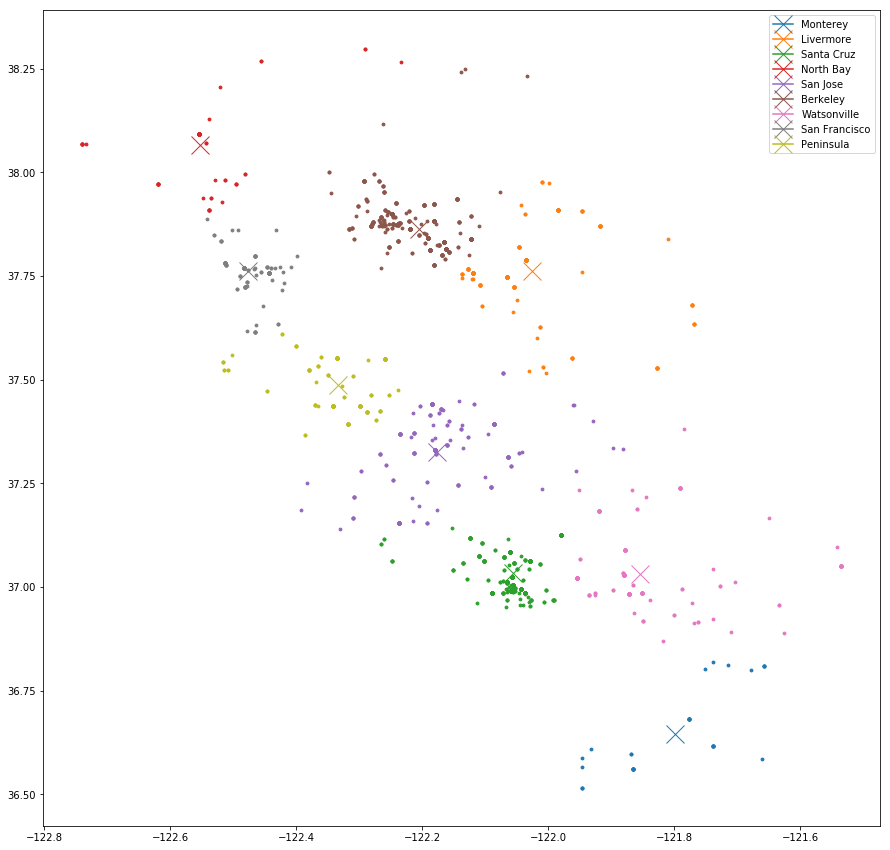

In [1909]:
from matplotlib.ticker import MultipleLocator

def create_cluster_plot(mush_df, n=9):
    spacingy = (38.4228 - 36.4557) / 275
    spacingx = (123.2710 - 121.5229) / 175
    minorLocatorx = MultipleLocator(spacingx)
    minorLocatory = MultipleLocator(spacingy)
    
    fig = plt.figure(figsize=(15,15))
    # ax = fig.gca()
    # ax.yaxis.set_minor_locator(minorLocatory)
    # ax.xaxis.set_minor_locator(minorLocatorx)
    # ax.grid(which = 'minor')
    
    for i in range(n):
        cluster = mush_df[mush_df['cluster'] == i]
        plt.scatter(cluster['longitude'], cluster['latitude'], s=8, cmap='viridis')
        c = centroids.iloc[i]
        plt.plot(c['long'], c['lat'], marker='x', markersize=18)
        plt.legend(cluster_dict.values())
    # plt.grid()
create_cluster_plot(clustered_mush)


# cluster_dict = {
#     0: 'Monterey', 1: 'Livermore', 2: 'Santa Cruz', 3: 'North Bay', 4: 'San Jose',
#     5: 'Berkeley', 6: 'Watsonville', 7: 'San Francisco', 8: 'Peninsula'
# }

# weather_1_df=SF, 2=Sonoma, 3=San Jose, 4=Santa Cruz, 5-Livermore, 6=Berkeley, 7-Monterey
# cluster_map = {0:7, 1:5, 2:4, 3:2, 4:3, 5:6, 6:7, 7:1, 8:3}

In [1910]:
def create_cluster_map(mush_df, n=9):
    fig, ax = plt.subplots(figsize=(15,15))
    x = edible_by_species['longitude']
    y = edible_by_species['latitude']

    for i in range(n):
        cluster = clustered_mush[clustered_mush['cluster']==i]
        plt.scatter(cluster['longitude'], cluster['latitude'], s=10, cmap='viridis')
        c = centroids.iloc[i]
        ax.plot(c['long'], c['lat'], marker='*', markersize=18)

    # plt.legend(cluster_dict.values())
    return mplleaflet.display(fig=fig)
    
create_cluster_map(clustered_mush)

In [2269]:
# edible_by_species_clustered = pd.concat([edible_by_species, clustered_mush['cluster']],axis=1)
clustered_mush.head(2)

id          created_at          text_name   latitude   longitude  \
0  24690 2009-08-24 08:54:47  Agaricus augustus  37.769001 -122.483501   
1  49632 2010-08-05 00:42:10  Agaricus augustus  37.769850 -122.466000   

   is_redwood  is_fir  is_oak  is_eucalyptus  is_manzanita  is_pine  \
0           0       0       0              0             0        1   
1           0       0       0              0             0        0   

   is_madrone  is_cypress  is_hardwood  is_grass  is_duff  is_rott  is_dung  \
0           0           0            0         0        0        0        0   
1           0           0            0         0        0        0        0   

   is_wood_chip grid_code  cluster  
0             0   367_157        7  
1             0   367_161        7

### Assign weather readings based on cluster number

In [2276]:
### weather stations
# weather_1_df=SF, 2=Sonoma, 3=San Jose, 4=Santa Cruz, 5-Livermore, 6=Berkeley, 7-Monterey

# cluster_dict = {
#     0: 'Monterey', 1: 'Livermore', 2: 'Santa Cruz', 3: 'North Bay', 4: 'San Jose',
#     5: 'Berkeley', 6: 'Watsonville', 7: 'San Francisco', 8: 'Peninsula'
# }

def assign_cluster_data(row, col):
    cluster_map = {0:7, 1:5, 2:4, 3:2, 4:3, 5:6, 6:7, 7:1, 8:3}
    weather_date_str = str(row['created_at'])[0:10]
    
    return w_all_df[(w_all_df['Date'] == weather_date_str) & (w_all_df['station'] == cluster_map[row['cluster']])][col].values[0]
    
def assign_station_data(mush_df):
    edible_by_species_clustered_weather['TMax'] = 0
    edible_by_species_clustered_weather['TMin'] = 0
    edible_by_species_clustered_weather['Precip'] = 0

    weather_assign_cols = ['TMax', 'TMin', 'Precip']
    for col in weather_assign_cols:
        mush_df[col] = mush_df.apply(lambda row: assign_cluster_data(row, col), axis=1)

    return mush_df

edible_by_species_clustered_weather = clustered_mush.copy()
edible_by_species_clustered_weather = assign_station_data(edible_by_species_clustered_weather)
edible_by_species_clustered_weather.head(2)

id          created_at          text_name   latitude   longitude  \
0  24690 2009-08-24 08:54:47  Agaricus augustus  37.769001 -122.483501   
1  49632 2010-08-05 00:42:10  Agaricus augustus  37.769850 -122.466000   

   is_redwood  is_fir  is_oak  is_eucalyptus  is_manzanita  is_pine  \
0           0       0       0              0             0        1   
1           0       0       0              0             0        0   

   is_madrone  is_cypress  is_hardwood  is_grass  is_duff  is_rott  is_dung  \
0           0           0            0         0        0        0        0   
1           0           0            0         0        0        0        0   

   is_wood_chip grid_code  cluster TMax TMin Precip  
0             0   367_157        7   64   54   0.00  
1             0   367_161        7   61   51   0.00

In [2270]:
# edible_by_species_clustered_weather[edible_by_species_clustered_weather['TMax'] == 0]

### Replace numeric cluster names with meaningful labels

In [2277]:
edible_by_species_clustered_weather = edible_by_species_clustered_weather.replace({'cluster': cluster_dict})
edible_by_species_clustered_weather.head(2)

id          created_at          text_name   latitude   longitude  \
0  24690 2009-08-24 08:54:47  Agaricus augustus  37.769001 -122.483501   
1  49632 2010-08-05 00:42:10  Agaricus augustus  37.769850 -122.466000   

   is_redwood  is_fir  is_oak  is_eucalyptus  is_manzanita  is_pine  \
0           0       0       0              0             0        1   
1           0       0       0              0             0        0   

   is_madrone  is_cypress  is_hardwood  is_grass  is_duff  is_rott  is_dung  \
0           0           0            0         0        0        0        0   
1           0           0            0         0        0        0        0   

   is_wood_chip grid_code        cluster TMax TMin Precip  
0             0   367_157  San Francisco   64   54   0.00  
1             0   367_161  San Francisco   61   51   0.00

### Export to .csv for Tableau

In [724]:
# edible_by_species_clustered_weather.to_csv('./data/edible_clustered_weather_named.csv', index=False)

### Fix non-numeric weather values

In [2279]:
edible_by_species_clustered_weather['Precip'] = edible_by_species_clustered_weather['Precip'].map(lambda x: str(x).rstrip('A'))
edible_by_species_clustered_weather['Precip'] = edible_by_species_clustered_weather['Precip'].replace('S', 0)

In [2280]:
def make_weather_data_numeric(mush_df):
    # edible_clustered_train['created_at'][0].toordinal()
    mush_df['TMax'] = mush_df['TMax'].astype(int)
    mush_df['TMin'] = mush_df['TMin'].astype(int)
    mush_df['Precip'] = mush_df['Precip'].astype(float)
    
    return mush_df

edible_by_species_clustered_weather = make_weather_data_numeric(edible_by_species_clustered_weather)
# edible_by_species_clustered_weather.dtypes
# len(edible_by_species_clustered_weather)

### Reassigning temporal data based on month as string and year as continuous

In [2281]:
def alter_time_data(mush_df):
    # edible_clustered_weather_train['created_at'] = edible_clustered_train['created_at'].map(lambda x: x.toordinal())
    mush_df['month'] = mush_df['created_at'].map(lambda row: row.month).astype(str)
    mush_df['year'] = mush_df['created_at'].map(lambda row: row.year)
    mush_df = mush_df.drop(['created_at'], axis=1)
    
    return mush_df

edible_by_species_clustered_weather = alter_time_data(edible_by_species_clustered_weather)
# edible_clustered_weather_train.dtypes
# edible_by_species_clustered_weather.tail(10)

### Make train and test sets

In [2282]:
X = edible_by_species_clustered_weather.copy()
y = label_enc.fit_transform(X['text_name'])
mush_labels = get_labels(label_enc)
X = X.drop(['id', 'latitude', 'longitude', 'text_name', 'cluster'], axis=1)
X = pd.get_dummies(X, columns=['grid_code', 'month'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=314)

### Running Several Different Models and SS/PCA Using Pipeline

In [2286]:
log_reg = LogisticRegression()
knn_clf = KNeighborsClassifier()
dt_clf = DecisionTreeClassifier()
bag_clf = BaggingClassifier()
rf_clf = RandomForestClassifier()
ada_clf = AdaBoostClassifier()
svc = SVC()
pca = PCA()

# models = {'log_reg': log_reg, 'knn_clf': knn_clf,  'dt_clf': dt_clf, 'bag_clf': bag_clf, 'rf_clf': rf_clf, 'ada_clf': ada_clf, 'svc': svc}
models = {'log_reg': log_reg, 'knn_clf': knn_clf, 'rf_clf': rf_clf, 'ada_clf': ada_clf, 'svc': svc}

### initialize score dictionary
scores = {}

for model_name, model in models.items():
    pipe = Pipeline(steps=[('ss', ss), ('pca', pca), (model_name, model)])
    feature_importances = ''

    params = {}
    if (model_name) == 'log_reg':
        params['log_reg__penalty'] = ['l1', 'l2']
        params['log_reg__C'] = np.arange(0.1, 2.0, 0.1)
    elif (model_name) == 'knn_clf':
        params['knn_clf__n_neighbors'] = (3, 7, 11, 15)
    elif (model_name) == 'dt_clf':
        params['dt_clf__max_depth'] = [5, 7, 10]
        params['dt_clf__min_samples_split'] = [3, 5, 7, 9]
        params['dt_clf__min_samples_leaf'] = [2, 4, 6, 8]
    elif (model_name) == 'bag_clf':
        params['bag_clf__n_estimators'] = [100, 150, 200]
        params['bag_clf__max_depth'] = [3, 4, 5, 6]
    elif (model_name) == 'rf_clf':
        params['rf_clf__n_estimators'] = np.arange(100, 200, 50)
        params['rf_clf__max_features'] = ['auto', 'sqrt', 'log2']
        params['rf_clf__max_depth'] = [20, 25, 30, 35, 40]
    elif (model_name) == 'ada_clf':
        params['ada_clf__n_estimators'] = [100, 150, 200]
        params['ada_clf__learning_rate'] = [.5, .7, 1.0] 
    elif (model_name) == 'svc':
        params['svc__C'] = np.arange(30, 35, 40)
        params['svc__kernel'] = ['rbf']
        params['svc__gamma'] = ['auto']

    gs = GridSearchCV(pipe, params)
    gs.fit(X_train, y_train)
    train_score = gs.best_score_
    # train_score = gs.score(X_train, y_train)
    # test_score = gs.score(X_test, y_test)
    best_estimator = gs.best_estimator_.steps[2][1]
    best_params = gs.best_params_
    # y_train_pred = best_estimator.predict(X_train)
    # y_test_pred = best_estimator.predict(X_test)
    
    try:
        coefs = best_estimator.coef_.ravel()
    except:
        coefs = ''    
    try:
        feature_importances = best_estimator.feature_importances_
    except:
        if model_name == 'knn_clf':
            skb.fit(X_train, y_train)
            feature_importances = skb.pvalues_
        # elif model_name == 'bag_clf':
        #     sfm = SelectFromModel(bag_reg)
        #     sfm.fit(X_train, y_train)
        #     feature_importances = sfm.get_support(indices=True)        
        else:
            feature_importances = ''
    
    scores[model_name] = {'train_score': train_score, 
                          # 'test_score': test_score, 
                          'best_params': best_params, 
                          'best_estimator': best_estimator,
                          'coefs': coefs,
                          'feature_importances': feature_importances,
                          # 'y_train_pred': y_train_pred,
                          # 'y_test_pred': y_test_pred
                          # 'cv_result': gs.cv_results_
                         }

scores

/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 25  29  33  39  42  50  59  60  67  85 113 116 136 140 150 152 155 170
 177 185 187 192 193 195 212 213 217 218 222 225 226 237 240 248 249 256
 257 260 270 280 293 302 308 319 327 335 339 348 351 372 381 389] are constant.
  UserWarning)
/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/

{'log_reg': {'train_score': 0.178359096313912,
  'best_params': {'log_reg__C': 0.30000000000000004, 'log_reg__penalty': 'l1'},
  'best_estimator': LogisticRegression(C=0.30000000000000004, class_weight=None, dual=False,
            fit_intercept=True, intercept_scaling=1, max_iter=100,
            multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
            solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
  'coefs': array([ -5.41366070e-01,  -2.23742864e-05,   1.25775603e-01, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00]),
  'feature_importances': ''},
 'knn_clf': {'train_score': 0.13436385255648037,
  'best_params': {'knn_clf__n_neighbors': 11},
  'best_estimator': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors=11, p=2,
             weights='uniform'),
  'coefs': '',
  'feature_importances': array([  3.40231545e-008,   6.18432824e-003,   9.53143156e-001,
   

In [2287]:
pd.set_option('max_colwidth',1000)

model_names = list(scores.keys())
train_score = []
test_score = []
coefs = []
feature_importances = []

for model, score_dict in scores.items():
    train_score.append(score_dict['train_score'])
    # test_score.append(score_dict['test_score'])
    coefs.append(score_dict['coefs'])
    feature_importances.append(score_dict['feature_importances'])

scores_df = pd.DataFrame({'train score': train_score, 'regression model': model_names, 'coefs': coefs, 'best_estimator': best_estimator})
scores_df

best_estimator  \
0  SVC(C=30, cache_size=200, class_weight=None, coef0=0.0,\n  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',\n  max_iter=-1, probability=False, random_state=None, shrinking=True,\n  tol=0.001, verbose=False)   
1  SVC(C=30, cache_size=200, class_weight=None, coef0=0.0,\n  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',\n  max_iter=-1, probability=False, random_state=None, shrinking=True,\n  tol=0.001, verbose=False)   
2  SVC(C=30, cache_size=200, class_weight=None, coef0=0.0,\n  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',\n  max_iter=-1, probability=False, random_state=None, shrinking=True,\n  tol=0.001, verbose=False)   
3  SVC(C=30, cache_size=200, class_weight=None, coef0=0.0,\n  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',\n  max_iter=-1, probability=False, random_state=None, shrinking=True,\n  tol=0.001, verbose=False)   
4  SVC(C=30, cache_size=200, class_weight=None, coef0=0.0,\n  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',\n  max_iter=-1, probability=False, random_state=None, shrinking=True,\n  tol=0.001, verbose=False)   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     coefs  \
0  [-0.541366069647, -2.23742863605e-05, 0.12577560338, 0.156108324862, 0.0, -0.154740207232, 0.0, -0.0122252412157, 0.0, 0.0, -0.311389045698, -0.0806719682616, 0.13241517136, 0.0, 0.0480997881548, 0.0, 0.0, -0.111035094844, 0.0755559316879, 0.0, 0.0, -0.0525310979468, -0.0718471688388, 0.0, 0.0, 0.0, 0.0, 0.504773659232, 0.0, 0.0, 0.0, 0.0, -0.0687586014311, 0.277451746701, 0.0, 0.0243197368778, -0.0929652746233, 0.0, 0.0, 0.0, 0.0, -0.0804831583092, 0.0, 0.0, 0.0965171788508, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0589528430981, 0.0317191191552, 0.053298078598, -0.0809205689335, 0.0, 0.104329984674, 0.0126360798008, 0.066373319391, 0.0, 0.0, 0.011909456498, 0.113492135769, 0.217131883239, 0.122242006559, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0385898311486, 0.0, 0.0, -0.100610380991, 0.0, 0.0, 0.0, 0.0944092515569, 0.0, 0.144860154776, 0.0, 0.0, 0.0, -0.112371586473, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0380752733711, -0.13384820876, 0.0, 0.0, 0.295978860967, 0.0, 0.0, -0.0297087519103, 0.0, 0.0, 0.0, 0.062216022...   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

### Pipeline without PCA or StandardScaler

In [2288]:
log_reg = LogisticRegression()
knn_clf = KNeighborsClassifier()
dt_clf = DecisionTreeClassifier()
bag_clf = BaggingClassifier()
rf_clf = RandomForestClassifier()
ada_clf = AdaBoostClassifier()
# svc = SVC()
# pca = PCA()

# models = {'log_reg': log_reg, 'knn_clf': knn_clf,  'dt_clf': dt_clf, 'bag_clf': bag_clf, 'rf_clf': rf_clf, 'ada_clf': ada_clf, 'svc': svc}
models = {'log_reg': log_reg, 'knn_clf': knn_clf, 'rf_clf': rf_clf, 'svc': svc}

### initialize score dictionary
scores2 = {}

for model_name, model in models.items():
    pipe = Pipeline(steps=[(model_name, model)])
    feature_importances = ''

    params = {}
    if (model_name) == 'log_reg':
        params['log_reg__penalty'] = ['l1', 'l2']
        params['log_reg__C'] = np.arange(0.5, 9.5, 0.5)
    elif (model_name) == 'knn_clf':
        params['knn_clf__n_neighbors'] = (7, 15)
    elif (model_name) == 'dt_clf':
        params['dt_clf__max_depth'] = [5, 7, 10]
        params['dt_clf__min_samples_split'] = [3, 5, 7, 9]
        params['dt_clf__min_samples_leaf'] = [2, 4, 6, 8]
    elif (model_name) == 'bag_clf':
        params['bag_clf__n_estimators'] = [45, 50, 55]
    elif (model_name) == 'rf_clf':
        params['rf_clf__n_estimators'] = np.arange(100, 200, 50)
        params['rf_clf__max_features'] = ['auto', 'sqrt', 'log2']
        params['rf_clf__max_depth'] = [20, 25, 30, 35, 40]
    elif (model_name) == 'ada_clf':
        params['ada_clf__n_estimators'] = [45, 50, 55]
        params['ada_clf__learning_rate'] = [.5, .7, 1.0] 
    elif (model_name) == 'svc':
        params['svc__C'] = np.arange(30, 35, 40)
        params['svc__kernel'] = ['rbf']
        params['svc__gamma'] = ['auto']

    gs = GridSearchCV(pipe, params)
    gs.fit(X_train, y_train)
    train_score = gs.best_score_
    # train_score = gs.score(X_train, y_train)
    # test_score = gs.score(X_test, y_test)
    best_estimator = gs.best_estimator_.steps[0][1]
    best_params = gs.best_params_
    # y_train_pred = best_estimator.predict(X_train)
    # y_test_pred = best_estimator.predict(X_test)
    
    try:
        coefs = best_estimator.coef_.ravel()
    except:
        coefs = ''    
    try:
        feature_importances = best_estimator.feature_importances_
    except:
        if model_name == 'knn_clf':
            skb.fit(X_train, y_train)
            feature_importances = skb.pvalues_
        # elif model_name == 'bag_clf':
        #     sfm = SelectFromModel(bag_reg)
        #     sfm.fit(X_train, y_train)
        #     feature_importances = sfm.get_support(indices=True)        
        else:
            feature_importances = ''
    
    scores2[model_name] = {'train_score': train_score, 
                          # 'test_score': test_score, 
                          'best_params': best_params, 
                          'best_estimator': best_estimator,
                          'coefs': coefs,
                          'feature_importances': feature_importances,
                          # 'y_train_pred': y_train_pred,
                          # 'y_test_pred': y_test_pred
                          # 'cv_result': gs.cv_results_
                         }

# scores2

/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 25  29  33  39  42  50  59  60  67  85 113 116 136 140 150 152 155 170
 177 185 187 192 193 195 212 213 217 218 222 225 226 237 240 248 249 256
 257 260 270 280 293 302 308 319 327 335 339 348 351 372 381 389] are constant.
  UserWarning)
/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/

In [2289]:
pd.set_option('max_colwidth', 1000)

model_names = list(scores2.keys())
train_score = []
test_score = []
coefs = []
feature_importances = []

for model, score_dict2 in scores2.items():
    train_score.append(score_dict2['train_score'])
    # test_score.append(score_dict['test_score'])
    coefs.append(score_dict2['coefs'])
    feature_importances.append(score_dict2['feature_importances'])

scores2_df = pd.DataFrame({'train score': train_score, 'regression model': model_names, 'coefs': coefs, 'feature importances': feature_importances})
scores2_df

coefs  \
0  [0.599450090738, -0.594905048076, -0.444721572142, -1.1348744885, -0.44147357874, 0.779454694106, -0.638376932236, 1.20065653258, -0.657735902175, 0.133254088707, 0.154727954839, -0.356453380337, -0.168558413995, 0.422724901182, -0.0040706937942, 0.0267685252681, 0.316729424285, -0.00222332566877, -0.0295628126748, -0.00609407620067, 1.16951044613, -0.0409710334207, -0.0163090377619, 2.20884912783, -0.0674905061337, 0.0, -0.0170797806603, -0.00881704326596, -0.0556842572098, 0.0, -0.00621812525284, -0.220298040451, -0.00618439418254, 0.0, -0.0468467981766, -0.0998142399206, -0.0234572522052, -0.0378500011172, -0.0166643656259, 0.0, -0.0938816787997, -0.0202403778664, 0.0, -0.127979043883, -0.0164146961878, -0.018201600352, -0.652505224288, -0.110789167214, -0.307522954918, -0.202722332796, 0.0, -0.0497477109228, -0.00638832235806, -0.0845426627153, -0.0371028269353, -0.250259106431, -0.00700556786429, 0.28244404271, -0.0748293830088, 0.0, 0.0, -0.0866611094026, -0.824150923515, 1.3...   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

## <span style="color:white">Modeling</span>

### Copying dataframe to manipulate in models to avoid regenerating

In [2190]:
ebscw = edible_by_species_clustered_weather.copy()
# ebscw = ebscw[ebscw['text_name'].isin(choice_mushroom_list)]

### Adjust date-related columns

In [2191]:
# ebscw['Precip'] = ebscw['Precip'].map(lambda x: str(x).rstrip('A'))
# ebscw['Precip'] = ebscw['Precip'].replace('S', 0)

In [2192]:
ebscw = make_weather_data_numeric(ebscw)
ebscw = alter_time_data(ebscw)

### Removing Outliers

In [2193]:
outliers = ['Hydnum repandum', 'Lentinula edodes', 'Amanita vaginata', 'Flammulina velutipes', 'Lactarius deliciosus']
ebscw = ebscw[-ebscw['text_name'].isin(outliers)]

### Adding LabelEncoder

In [2195]:
label_enc = LabelEncoder()

def get_labels(le):
    '''
    Convenience function to return discrete ordered list of labels
    '''
    return le.classes_

def decode_labels(le, labelled_series):
    '''
    Returns species name from encoded label using fitted LabelEncoder instance
    '''
    decoded = le.inverse_transform(labelled_series)
    return decoded

### Functions to return top <i>n</i> probabilities for each row into new column

In [2196]:
def find_highest_probs(row, top_num=3):
    '''
    Returns top n highest probs into new row
    '''
    proba_list = row.nlargest(top_num)
    return ",".join(list(proba_list.index))

def get_probas_from_test(target, test_df, model, top_num=3):
    '''
    Returns df with top n species probabilities appended to each row (for each observation)
    '''
    probas = model.predict_proba(target)
    probas_df = pd.DataFrame(probas, index=test_df.index)
    probas_df.columns = mush_labels

    probas_df['proba_list'] = probas_df.T.apply(lambda row: find_highest_probs(row, top_num))
    
    return probas_df

### Functions to analyze predicted output

In [2197]:
def filter_preds_df(row):
    '''
    Mask to only return matching rows from predictions dataframe
    '''
    return row['actual'] in row['proba_list']

def analyze_preds(actuals, probas, test_df, le):
    '''
    Decodes target labels and returns matching rows for actual in predicted n species string
    '''
    actual_vals = decode_labels(le, actuals)
    preds_df = pd.DataFrame(data=None, index=X_test.index)
    preds_df['actual'] = pd.Series(decode_labels(le, actuals), index=X_test.index)
    preds_df['proba_list'] = pd.Series(probas['proba_list'], index=X_test.index)

    preds_df_filter = preds_df.apply(filter_preds_df, axis=1)
    matches = preds_df[preds_df_filter]
    
    return matches

### Function to output multiclass confusion matrix

In [2198]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    '''
    Sourced from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    '''
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size='18', color='k')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True species', size='14', color='k')
    # plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass), size='14', color='k')
    plt.xlabel('Predicted species')
    plt.show()

### Running LogisticRegression without PCA/SS

In [2213]:
X = ebscw.copy()
y = label_enc.fit_transform(X['text_name'])
mush_labels = get_labels(label_enc)
X = X.drop(['id', 'latitude', 'longitude', 'text_name', 'cluster'], axis=1)
X = pd.get_dummies(X, columns=['grid_code', 'month'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=314)

log_reg = LogisticRegression(C=0.5, penalty='l2')
log_reg.fit(X_train, y_train)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [2214]:
y_preds = log_reg.predict(X_test)
y_preds_lr = label_enc.inverse_transform(y_preds)

cross_val_score(log_reg, X_train, y_train), cross_val_score(log_reg, X_test, y_test)

(array([ 0.1842576 ,  0.18165138,  0.16356877]),
 array([ 0.15102041,  0.18220339,  0.15625   ]))

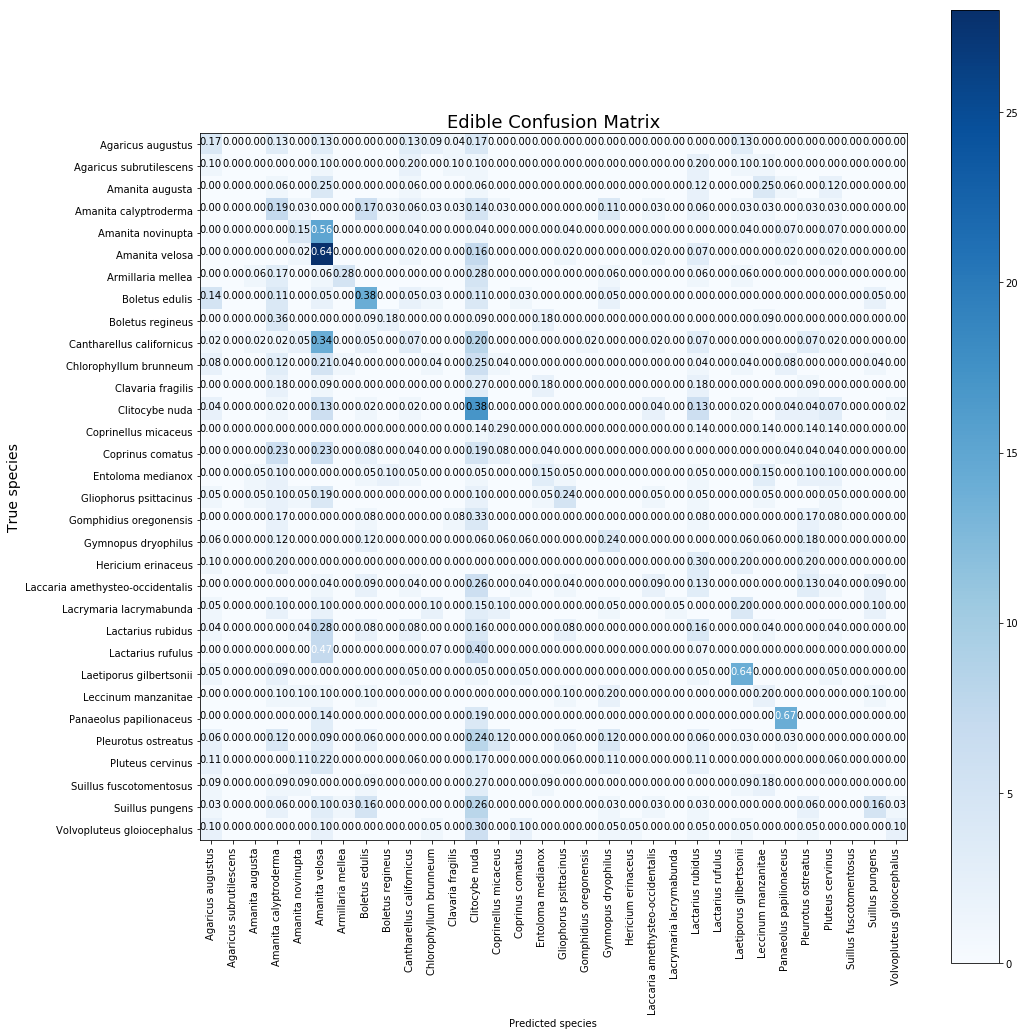

In [2215]:
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

pca_cm = confusion_matrix(label_enc.inverse_transform(y_test), y_preds_lr)
plot_confusion_matrix(pca_cm, mush_labels, title='Edible Confusion Matrix')

### Run functions to analyze top three accuracy score

In [2216]:
probas_df = get_probas_from_test(X_test, X_test, log_reg)

matches_df = analyze_preds(y_test, probas_df, X_test, label_enc)
len(matches_df), len(matches_df)/len(X_test)

(279, 0.39574468085106385)

### Running LogisticRegression and PCA

In [2217]:
pca = PCA()

X = ebscw.copy()
y = label_enc.fit_transform(X['text_name'])
mush_labels = get_labels(label_enc)
X = X.drop(['id', 'latitude', 'longitude', 'text_name', 'cluster'], axis=1)
X = pd.get_dummies(X, columns=['grid_code', 'month'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=314)

X_train_ss = ss.fit_transform(X_train)
pca.fit(X_train_ss)
X_train_ss_pca = pca.transform(X_train_ss)

log_reg = LogisticRegression(C=0.5, penalty='l1')
log_reg.fit(X_train_ss_pca, y_train)

/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


array([ 0.17710197,  0.1853211 ,  0.15241636])

In [2218]:
X_test_ss = ss.transform(X_test)
X_test_ss_pca = pca.transform(X_test_ss)

y_preds = log_reg.predict(X_test_ss_pca)
y_preds_lr = label_enc.inverse_transform(y_preds)
cross_val_score(log_reg, X_train_ss_pca, y_train), cross_val_score(log_reg, X_test_ss_pca, y_test)

(array([ 0.17710197,  0.1853211 ,  0.15241636]),
 array([ 0.14285714,  0.16949153,  0.13392857]))

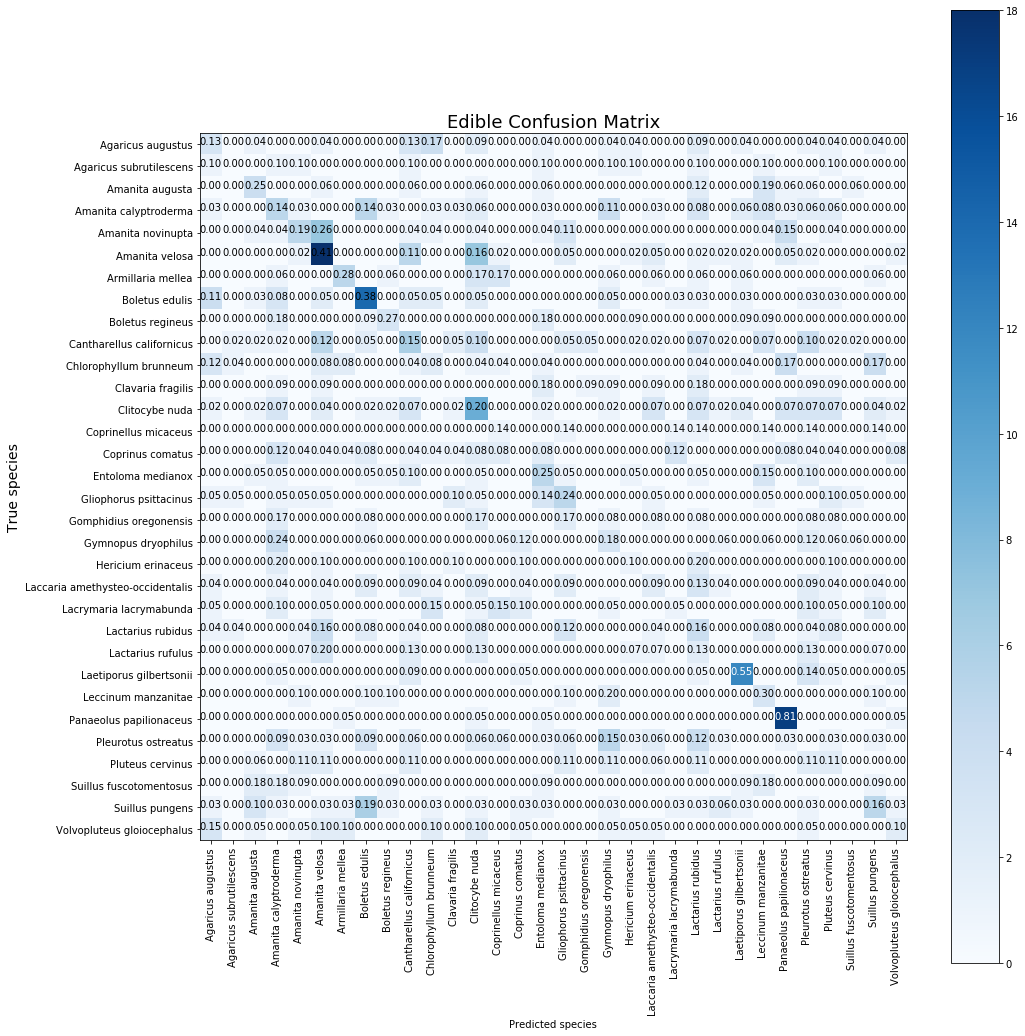

In [2219]:
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

pca_cm = confusion_matrix(label_enc.inverse_transform(y_test), y_preds_lr)
plot_confusion_matrix(pca_cm, mush_labels, title='Edible Confusion Matrix')

### Run functions to analyze top three accuracy score

In [2222]:
probas_df = get_probas_from_test(X_test_ss_pca, X_test, log_reg)

matches_df = analyze_preds(y_test, probas_df, X_test, label_enc)
len(matches_df), len(matches_df)/len(X_test)

(251, 0.35602836879432626)

### Running RandomForestClassifier and PCA

In [2232]:
pca = PCA()

X = ebscw.copy()
y = label_enc.fit_transform(X['text_name'])

X = X.drop(['id', 'latitude', 'longitude', 'text_name', 'cluster'], axis=1)
X = pd.get_dummies(X, columns=['grid_code', 'month'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=314)

X_train_ss = ss.fit_transform(X_train)
pca.fit(X_train_ss)
X_train_ss_pca = pca.transform(X_train_ss)

rf_clf = RandomForestClassifier(n_estimators=100, max_depth=35, max_features='auto')
rf_clf.fit(X_train_ss_pca, y_train)

X_test_ss = ss.transform(X_test)
X_test_ss_pca = pca.transform(X_test_ss)

y_preds_rf = rf_clf.predict(X_test_ss_pca)
cross_val_score(rf_clf, X_train_ss_pca, y_train), cross_val_score(rf_clf, X_test_ss_pca, y_test)

(array([ 0.14669052,  0.14311927,  0.11152416]),
 array([ 0.14693878,  0.16949153,  0.11607143]))

### Run functions to analyze top three accuracy score

In [2234]:
probas_df = get_probas_from_test(X_test_ss_pca, X_test, rf_clf)

matches_df = analyze_preds(y_test, probas_df, X_test, label_enc)
len(matches_df), len(matches_df)/len(X_test)

(244, 0.34609929078014184)

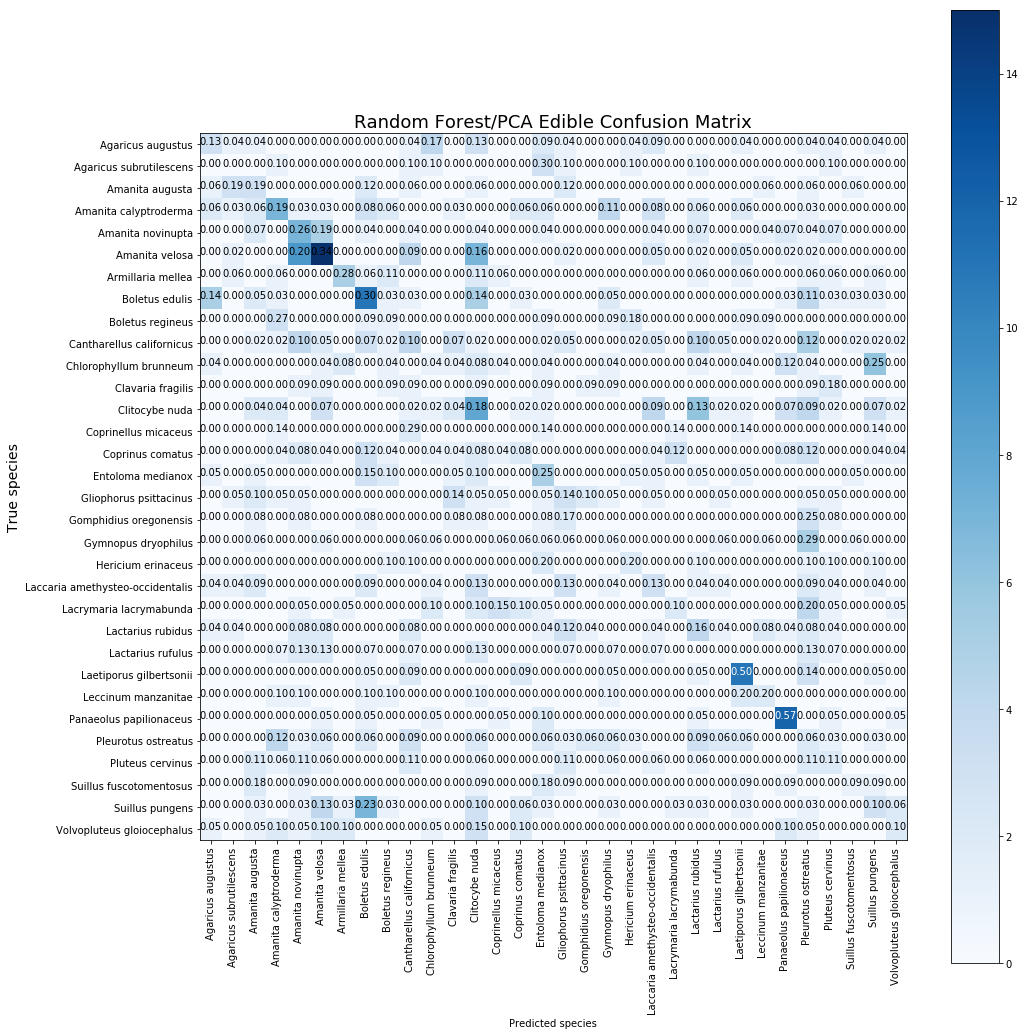

In [2235]:
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

pca_cm = confusion_matrix(label_enc.inverse_transform(y_test), label_enc.inverse_transform(y_preds_rf))
plot_confusion_matrix(pca_cm, mush_labels, title='Random Forest/PCA Edible Confusion Matrix')

### Running SVC without PCA/SS

In [2246]:
X = ebscw.copy()
y = label_enc.fit_transform(X['text_name'])
X = X.drop(['id', 'latitude', 'longitude', 'text_name', 'cluster'], axis=1)
X = pd.get_dummies(X, columns=['grid_code', 'month'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=314)

svc = SVC(C=30.0, kernel='rbf', gamma='auto', probability=True)
svc.fit(X_train, y_train)

SVC(C=30.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [2247]:
y_preds_svc = svc.predict(X_test)
cross_val_score(svc, X_train, y_train), cross_val_score(svc, X_test, y_test)

(array([ 0.1216458 ,  0.12293578,  0.12453532]),
 array([ 0.11428571,  0.12288136,  0.08482143]))

### Run functions to analyze top three accuracy score

In [2248]:
probas_df = get_probas_from_test(X_test, X_test, svc)

matches_df = analyze_preds(y_test, probas_df, X_test, label_enc)
len(matches_df), len(matches_df)/len(X_test)

(209, 0.29645390070921984)

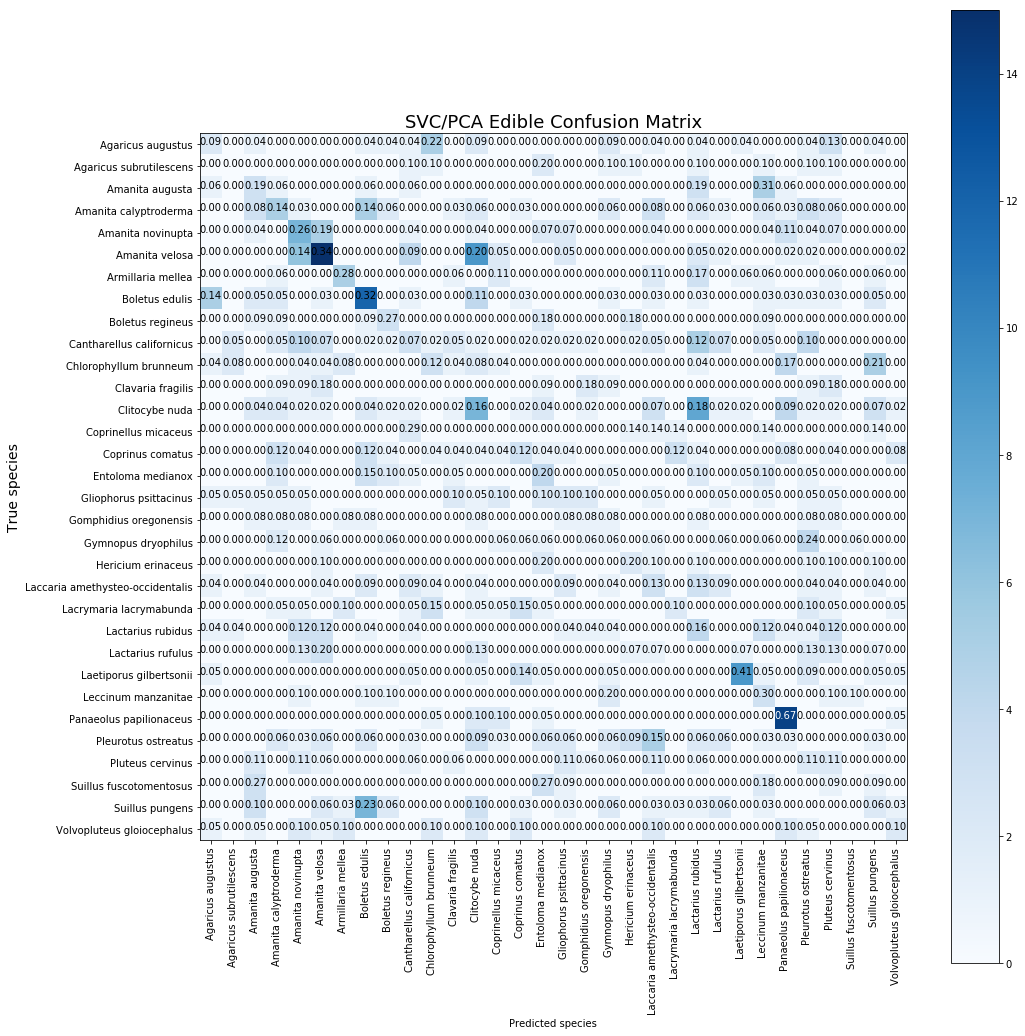

In [2255]:
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

pca_cm = confusion_matrix(label_enc.inverse_transform(y_test), label_enc.inverse_transform(y_preds_svc))
plot_confusion_matrix(pca_cm, mush_labels, title='SVC/PCA Edible Confusion Matrix')

### Running SVC with SS/PCA

In [2256]:
pca = PCA()

X = ebscw.copy()
y = label_enc.fit_transform(X['text_name'])
X = X.drop(['id', 'latitude', 'longitude', 'text_name', 'cluster'], axis=1)
X = pd.get_dummies(X, columns=['grid_code', 'month'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=314)

In [2257]:
X_train_ss = ss.fit_transform(X_train)
pca.fit(X_train_ss)
X_train_ss_pca = pca.transform(X_train_ss)

svc = SVC(C=40.0, kernel='rbf', gamma='auto', probability=True)
svc.fit(X_train_ss_pca, y_train)

SVC(C=40.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [2259]:
X_test_ss = ss.transform(X_test)
X_test_ss_pca = pca.transform(X_test_ss)

y_preds_svc = svc.predict(X_test_ss_pca)
cross_val_score(svc, X_train_ss_pca, y_train), cross_val_score(svc, X_test_ss_pca, y_test)

(array([ 0.15205725,  0.15412844,  0.15241636]),
 array([ 0.15510204,  0.15677966,  0.125     ]))

### Run functions to analyze top three accuracy score

In [2260]:
probas_df = get_probas_from_test(X_test_ss_pca, X_test, svc)

matches_df = analyze_preds(y_test, probas_df, X_test, label_enc)
len(matches_df), len(matches_df)/len(X_test)

(265, 0.375886524822695)

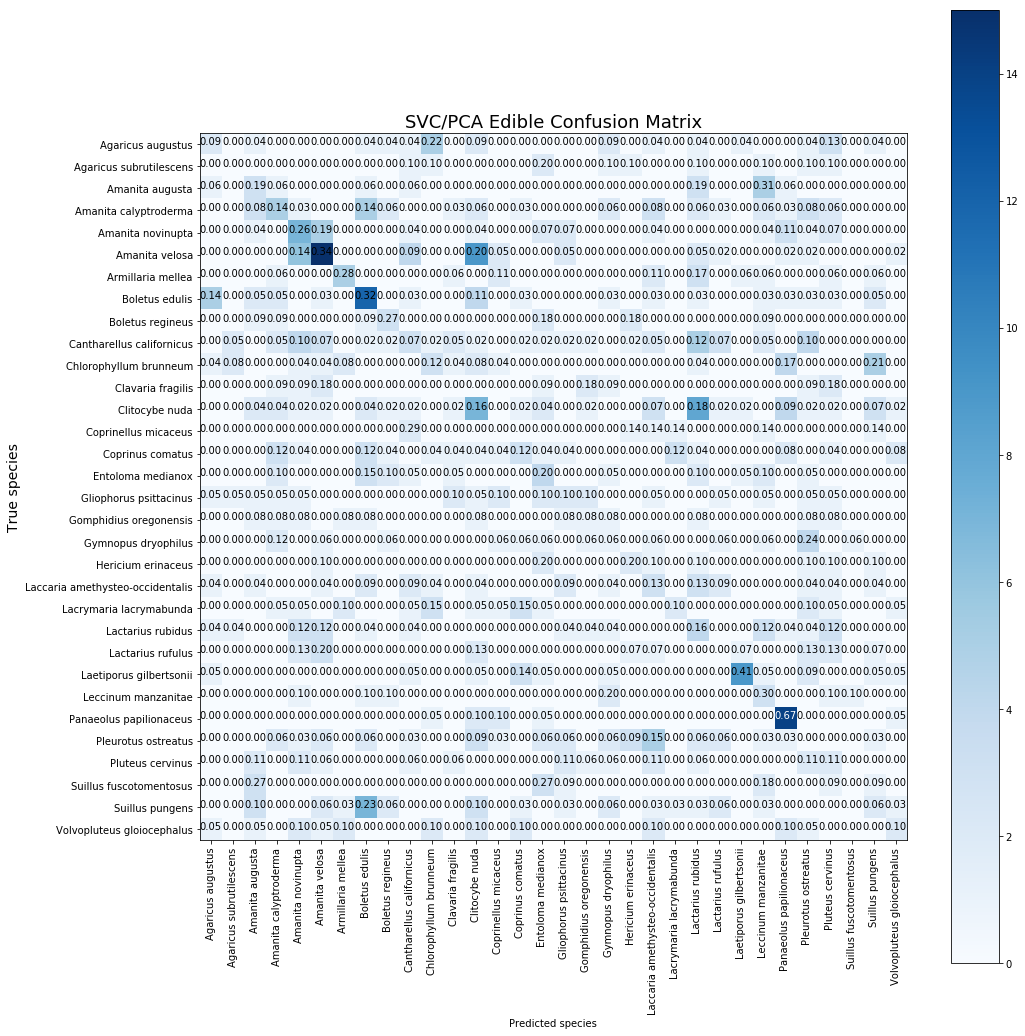

In [2261]:
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

pca_cm = confusion_matrix(label_enc.inverse_transform(y_test), label_enc.inverse_transform(y_preds_svc))
plot_confusion_matrix(pca_cm, mush_labels, title='SVC/PCA Edible Confusion Matrix')

In [2262]:
probas_df = get_probas_from_test(X_test_ss_pca, X_test, svc)

matches_df = analyze_preds(y_test, probas_df, X_test, label_enc)
len(matches_df), len(matches_df)/len(X_test)

(265, 0.375886524822695)

## <span style="color:white">Visualizations</span>

### <span style="color:#CCC">Edible Mushrooms By Name, Cluster, and Date Found</span>

https://public.tableau.com/profile/chris.huber#!/vizhome/BayAreaEdibleMushroomsByName/EdibleMushroomsbyName

### <span style="color:#CCC">Bay Area Temperatures</span>

https://public.tableau.com/profile/chris.huber#!/vizhome/BayAreaEdibleMushrooms/WeatherConditionsByCluster?publish=yes

In [1729]:
def mushroom_count_by_year(species_list):
    species_input = '|'.join(species_list)
    # return species_input
    query = "SELECT count(bay_area_observations.id) AS mushroom_count, YEAR(bay_area_observations.created_at) AS obsv_year FROM bay_area_observations LEFT JOIN bay_area_names ON bay_area_observations.name_id = bay_area_names.id WHERE bay_area_names.text_name REGEXP ('" + species_input + "') GROUP BY obsv_year;"
    # return query
    mush_by_species_df = pd.read_sql(query, con=mysql_cn)
    return mush_by_species_df    

# choice_by_year = mushroom_count_by_year(choice_mushroom_list)
edible_by_year = mushroom_count_by_year(choice_mushroom_list + edible_mushroom_list + not_choice_mushroom_list)
# poisonous_by_year = mushroom_count_by_year(poisonous_mushroom_list)
# psychoactive_by_year = mushroom_count_by_year(psychoactive_mushroom_list)
# other_by_year = mushroom_count_by_year(other_mushroom_list)

# choice_by_year[choice_by_year['obsv_year'] == 2010].head()
edible_by_year
# edible_by_year

mushroom_count  obsv_year
0   43              2006     
1   82              2007     
2   76              2008     
3   257             2009     
4   346             2010     
5   228             2011     
6   237             2012     
7   144             2013     
8   323             2014     
9   212             2015     
10  218             2016     
11  153             2017     
12  85              2018

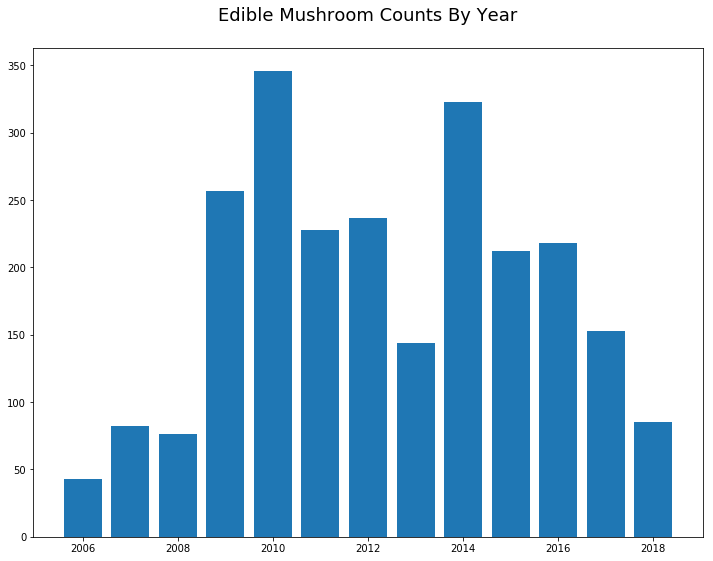

In [1755]:
def chart_mushroom_counts(mushroom_df, prefix=''):
    df = pd.DataFrame
    plt.figure(figsize=(12, 9))
    # plt.xticks(rotation=90)
    plt.title(prefix + ' Mushroom Counts By Year\n', fontsize='18', color='k')
    # plt.plot(mushroom_df['text_name'].groupby(['obsv_year']).sum())
    # df = mushroom_df.groupby(['obsv_year', 'text_name']).sum()['name_count'].unstack()
    plt.bar(mushroom_df['obsv_year'], mushroom_df['mushroom_count'])
    # plt.legend(df.columns)

chart_mushroom_counts(edible_by_year, 'Edible')

In [172]:
# poisonous_by_year.groupby(['obsv_year', 'text_name']).sum()['name_count'].unstack().columns

In [1211]:
# poisonous_by_year
# chart_mushroom_counts(poisonous_by_year, 'Poisonous')

In [1210]:
# chart_mushroom_counts(psychoactive_by_year, 'Psychoactive')

In [1209]:
# chart_mushroom_counts(other_by_year, 'Other')

In [1208]:
def chart_mushroom_counts(mushroom_df):
    plt.figure(figsize=(15, 9))
    plt.xticks(rotation=90)
    plt.title('Mushroom Count By Year\n', fontsize='18', color='w')
    # plt.plot(mushroom_df['text_name'].groupby(['obsv_year']).sum())
    
    plt.plot(mushroom_df['text_name'].groupby(['obsv_year']).count())

# chart_mushroom_counts(choice_by_year)

### Close MySQL connection

In [ ]:
mysql_cn.close()